In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
from torch.utils.data import TensorDataset,DataLoader
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
from torchvision import models

from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler,normalize
import sklearn

import numpy as np
import pickle
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
relations = pd.read_json('../visualgeno/relationships.json')

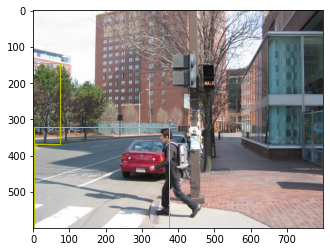

subject:  tree
object:  road
relation:  next to


In [45]:

def plot_example(idx, re_idx, relations):
    img_id = relations.iloc[idx]['image_id']
    re = relations.iloc[idx]['relationships'][re_idx]
    path = '../visualgeno/VG_100K/{}.jpg'.format(img_id)
    path = path if os.path.isfile(path) else '../visualgeno/VG_100K_2/{}.jpg'.format(img_id)
    img = mpimg.imread(path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    pat_subject = patches.Rectangle((re['subject']['x'],re['subject']['y']),re['subject']['w'],re['subject']['h'],
                            color='y',
                            fill=False)
    pat_object = patches.Rectangle((re['object']['x'],re['object']['y']),re['object']['w'],re['object']['h'],
                            color='y',
                            fill=False)
    ax.add_patch(pat_subject)
    ax.add_patch(pat_object)
    plt.show()
    
    name_pred = re['predicate']
    name_subj = re['subject']['name'] if 'name' in re['subject'] else re['subject']['names']
    name_obj = re['object']['name'] if 'name' in re['object'] else re['object']['names']
    print('subject: ',name_subj)
    print('object: ',name_obj)
    print('relation: ',name_pred)

plot_example(1,2, relations)

In [7]:
relations.shape[0]/3000

36.025666666666666

## Preparing data

In [3]:
def crop_image(img,obj):
    
    return img[obj['y']:obj['y']+obj['h'],
               obj['x']:obj['x']+obj['w'],:]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [5]:

model = models.resnet101(pretrained=True)
resnet = torch.nn.Sequential(*(list(model.children())[:-1]))
resnet.to(device)
resnet.eval()

data_cut = 3000
Image_batch_size = 20000
data_sect_cnt = 0
poolavg = torch.nn.AvgPool1d(16)


for section in range(36):
    data_startpoint = section*data_cut
    
    X,Y = [],[]
    print('data loading')
    for i in tqdm(range(data_startpoint, data_startpoint+data_cut)):
        img_id = relations.iloc[i]['image_id']
        path = '../visualgeno/VG_100K/{}.jpg'.format(img_id)
        path = path if os.path.isfile(path) else '../visualgeno/VG_100K_2/{}.jpg'.format(img_id)

        img_pred = mpimg.imread(path)
        if len(img_pred.shape)<3:
            continue

        for n, relation in enumerate(relations.iloc[i]['relationships']):
            img_subj = crop_image(img_pred,relation['subject'])
            img_obj = crop_image(img_pred,relation['object'])
            if (0 in img_subj.shape) or (0 in img_obj.shape):
                print('skip one broken image')
                continue

            name_pred = relation['predicate']
            name_subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
            name_obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
            X.append([img_pred, img_subj, img_obj])
            Y.append([name_pred, name_subj, name_obj])
            
    
    #looping
    print('X length:', len(X))
    Image_batch_number = np.floor(len(X)/Image_batch_size)
    x_hidden = []
    Y_flat = []
    for start_point in range(0,len(X),Image_batch_size):
        end_point = start_point+Image_batch_size if start_point+Image_batch_size<len(X) else len(X) 

        X_transformed = []
        print('image transforming')
        for row in tqdm(X[start_point:end_point]):
            X_transformed += [transform(img) for img in row]
        X_transformed = torch.cat(X_transformed).reshape((-1,3,224,224)) # the X_transformed is 10000*3*224*224

        x_loader = DataLoader(X_transformed,batch_size=500)
        del X_transformed
        with torch.no_grad():     # have to use no_grad() otherwise there will be memory leck
            output = []
            print('passing CNN')
            for x_batch in tqdm(x_loader):
                output_batch = resnet(x_batch.to(device))
                output.append(output_batch)
                
        del x_loader
        x_hidden.append(poolavg(torch.cat(output).cpu().reshape((-1,2048)).reshape((-1,3,2048)))*13)
        del output
        
        for row in Y[start_point:end_point]:
            Y_flat += row
    pickle.dump(np.concatenate(x_hidden), open("../data_v1/x_preprocessed_{}.p".format(section), "wb"))
    pickle.dump(np.array(Y_flat), open("../data_v1/y_preprocessed_{}.p".format(section), "wb"))
    del x_hidden
    del Y_flat
    data_sect_cnt += 1
    
    


  0%|          | 2/2000 [00:00<01:50, 18.14it/s]

data loading


  0%|          | 0/20000 [00:00<?, ?it/s]/home/yl535/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


X length: 43407
image transforming


  0%|          | 0/120 [00:00<?, ?it/s]

passing CNN


  0%|          | 32/20000 [00:00<01:03, 315.56it/s]

image transforming


  1%|          | 1/120 [00:00<00:12,  9.62it/s]

passing CNN


  1%|          | 37/3407 [00:00<00:09, 363.57it/s]

image transforming


  0%|          | 0/21 [00:00<?, ?it/s]

passing CNN


  0%|          | 2/2000 [00:00<01:44, 19.09it/s]

data loading


  0%|          | 37/20000 [00:00<00:55, 361.64it/s]

X length: 45971
image transforming


  1%|          | 1/120 [00:00<00:12,  9.72it/s]

passing CNN


  0%|          | 35/20000 [00:00<00:57, 348.47it/s]

image transforming


  1%|          | 1/120 [00:00<00:13,  9.14it/s]

passing CNN


  1%|          | 36/5971 [00:00<00:16, 356.04it/s]

image transforming


  3%|▎         | 1/36 [00:00<00:03,  9.39it/s]

passing CNN


  0%|          | 2/2000 [00:00<01:46, 18.68it/s]

data loading


  0%|          | 29/20000 [00:00<01:10, 281.54it/s]

X length: 43568
image transforming


  1%|          | 1/120 [00:00<00:13,  8.73it/s]

passing CNN


  0%|          | 36/20000 [00:00<00:55, 358.07it/s]

image transforming


  1%|          | 1/120 [00:00<00:14,  8.04it/s]

passing CNN


  1%|          | 38/3568 [00:00<00:09, 370.84it/s]

image transforming


  0%|          | 0/22 [00:00<?, ?it/s]

passing CNN


  0%|          | 2/2000 [00:00<01:43, 19.36it/s]

data loading


  0%|          | 19/20000 [00:00<01:50, 181.24it/s]

X length: 46102
image transforming


  1%|          | 1/120 [00:00<00:13,  8.99it/s]

passing CNN


  0%|          | 37/20000 [00:00<00:54, 365.31it/s]

image transforming


  1%|          | 1/120 [00:00<00:11,  9.93it/s]

passing CNN


  0%|          | 11/6102 [00:00<00:55, 109.64it/s]

image transforming


  3%|▎         | 1/37 [00:00<00:04,  8.85it/s]

passing CNN


  0%|          | 4/2000 [00:00<01:18, 25.45it/s]

data loading


  0%|          | 21/20000 [00:00<01:37, 204.53it/s]

X length: 50685
image transforming


  1%|          | 1/120 [00:00<00:13,  9.02it/s]

passing CNN


  0%|          | 13/20000 [00:00<02:34, 129.23it/s]

image transforming


  1%|          | 1/120 [00:00<00:13,  9.04it/s]

passing CNN


  0%|          | 32/10685 [00:00<00:33, 313.65it/s]

image transforming


  2%|▏         | 1/65 [00:00<00:07,  9.02it/s]

passing CNN


  0%|          | 3/2000 [00:00<01:30, 21.97it/s]

data loading


  0%|          | 28/20000 [00:00<01:12, 275.19it/s]

X length: 44599
image transforming


  1%|          | 1/120 [00:00<00:15,  7.68it/s]

passing CNN


  0%|          | 32/20000 [00:00<01:03, 312.19it/s]

image transforming


  1%|          | 1/120 [00:00<00:13,  8.95it/s]

passing CNN


  1%|          | 35/4599 [00:00<00:13, 348.52it/s]

image transforming


  4%|▎         | 1/28 [00:00<00:02,  9.31it/s]

passing CNN


  0%|          | 2/2000 [00:00<01:41, 19.66it/s]

data loading


  0%|          | 24/20000 [00:00<01:24, 235.23it/s]

X length: 44821
image transforming


  1%|          | 1/120 [00:00<00:12,  9.80it/s]

passing CNN


  0%|          | 35/20000 [00:00<00:58, 342.07it/s]

image transforming


  1%|          | 1/120 [00:00<00:13,  8.97it/s]

passing CNN


  1%|          | 31/4821 [00:00<00:15, 307.67it/s]

image transforming


  3%|▎         | 1/29 [00:00<00:03,  8.75it/s]

passing CNN


  0%|          | 3/2000 [00:00<01:34, 21.08it/s]

data loading


  0%|          | 27/20000 [00:00<01:14, 266.72it/s]

X length: 42834
image transforming


  1%|          | 1/120 [00:00<00:12,  9.53it/s]

passing CNN


  0%|          | 32/20000 [00:00<01:04, 311.31it/s]

image transforming


  1%|          | 1/120 [00:00<00:13,  9.08it/s]

passing CNN


  0%|          | 2/2834 [00:00<02:49, 16.67it/s]

image transforming


  6%|▌         | 1/18 [00:00<00:01,  9.56it/s]

passing CNN


  0%|          | 2/2000 [00:00<02:08, 15.59it/s]

data loading


  0%|          | 2/20000 [00:00<18:04, 18.44it/s]

X length: 45564
image transforming


  1%|          | 1/120 [00:00<00:12,  9.70it/s]

passing CNN


  0%|          | 34/20000 [00:00<00:59, 333.91it/s]

image transforming


  1%|          | 1/120 [00:00<00:12,  9.74it/s]

passing CNN


  1%|          | 35/5564 [00:00<00:15, 349.14it/s]

image transforming


  3%|▎         | 1/34 [00:00<00:03,  9.67it/s]

passing CNN


100%|██████████| 34/34 [00:28<00:00,  1.19it/s]


## cleaning data

In [3]:
# predicate_list = np.array([])
predicate_list = []
tokenizer = get_tokenizer("basic_english")

for itr in range(35):
    Y_flat = pickle.load(open("../data_v1/y_preprocessed_{}.p".format(itr), "rb"))
    y_2 = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat])
#     predicate_list = np.unique(np.concatenate((predicate_list,y_2)))
    predicate_list.append(y_2)
    
predicate_list, predicate_count = np.unique(np.concatenate(predicate_list),return_counts=True)
predicates_table = {w:i for i,w in enumerate(predicate_list)}
predicate_size = len(predicates_table)
predicate_size

19157

In [4]:
rare_pred = predicate_list[predicate_count<5]
rare_pred.shape

(11418,)

In [5]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gloveModel = loadGloveModel("../glove.42B.300d.txt")
glove_vocab = gloveModel.keys()
del gloveModel

Loading Glove Model
1917494  words loaded!


In [6]:
# filter by glove vocab and rare words
clean_pred_list = []
for pred in predicate_list:
    if (pred.lower() in glove_vocab) and (pred not in rare_pred):
        clean_pred_list.append(pred)
        
predicate_list.shape, len(clean_pred_list)

((19157,), 7604)

In [7]:
pixie_dim=128

for itr in tqdm(range(28,35)):
    x_hidden = pickle.load(open("../data_v1/x_preprocessed_{}.p".format(itr), "rb"))
    Y_flat = pickle.load(open("../data_v1/y_preprocessed_{}.p".format(itr), "rb"))
    
    Y_flat.reshape(-1,3).shape,x_hidden.shape
    x_processed = torch.Tensor([])
    y_processed = []
    for x, y in zip(x_hidden,Y_flat.reshape(-1,3)):
        if np.sum([y_pred=='' for y_pred in y])>0:
            continue
        if np.sum([tokenizer(y_pred)[0] not in clean_pred_list for y_pred in y]) != 0:
            continue
        x_processed = torch.cat((x_processed, torch.Tensor(x)))
        y_processed.append([tokenizer(y_pred)[0] for y_pred in y])
    pickle.dump(x_processed.reshape(-1,3,pixie_dim), open("../data_v1_preprocessed/x_preprocessed_{}.p".format(itr), "wb"))
    pickle.dump(np.array(y_processed), open("../data_v1_preprocessed/y_preprocessed_{}.p".format(itr), "wb"))

100%|██████████| 7/7 [25:22<00:00, 217.54s/it]


In [54]:
x_processed.reshape(-1,3,pixie_dim), len(y_processed), 39177*3

(torch.Size([117531, 128]), 39177, 117531)

In [96]:
flag_in_list = [word in clean_pred_list for word in Y_flat]

In [99]:
Y_flat[flag_in_list].shape

(82600,)

In [104]:
x_hidden.reshape(-1,pixie_dim)[flag_in_list,:].shape

(82600, 128)

In [43]:
Y_flat.reshape(-1,3).shape,x_hidden.shape
x_processed = torch.Tensor([])
y_processed = []
for x, y in zip(x_hidden,Y_flat.reshape(-1,3)):
    if np.sum([tokenizer(yw)[0] not in clean_pred_list for yw in y]) != 0:
        continue
    x_processed = torch.cat((x_processed, torch.Tensor(x)))
    y_processed.append([tokenizer(y_pred)[0] for y_pred in y])
#     y_processed = torch.cat((y_processed, torch.Tensor([tokenizer(y_pred)[0] for y_pred in y])))


In [47]:
x_processed.shape

torch.Size([117531, 128])

In [53]:
x_hidden.reshape(-1,1000)
pool = torch.nn.AvgPool1d(50)
x_pooled = pool(x_hidden).reshape(-1,30)

In [57]:
diff = x_pooled - torch.mean(x_pooled,0)
c = torch.mm(diff.T,diff)/x_pooled.shape[0]
weight = 1
torch.inverse(c*weight),c*weight

(tensor([[ 1.4057e+01, -7.4507e+00, -3.7625e+00,  3.5702e+00, -1.5037e+00,
          -1.7284e+00, -1.5435e+00, -5.0500e-01, -1.3274e+00,  7.1763e-01,
          -1.0890e-01,  7.4625e-01,  5.5967e-01,  1.2139e+00, -2.7091e-01,
          -3.0937e-02,  1.0093e+00,  1.2954e-01,  9.3616e-01,  8.5726e-01,
          -3.3171e+00,  1.7610e+00,  6.3149e-01, -7.6536e-01,  6.4376e-01,
          -4.4140e-03,  7.9191e-01,  3.4851e-01,  9.1610e-01, -5.3673e-01],
         [-7.4506e+00,  1.6383e+01, -1.2678e+00, -1.6575e+00,  1.8106e+00,
           6.9453e-01, -2.9876e+00, -2.9914e+00, -1.4145e+00,  2.4312e+00,
           4.9675e-01, -1.2849e-01,  2.8018e-01,  9.0796e-01, -7.4441e-01,
          -2.8476e-01, -6.8709e-01, -5.0056e-01, -7.3277e-01,  4.8358e-01,
           2.0063e+00, -3.4401e+00,  5.5007e-01,  5.5026e-01, -3.5183e-01,
          -3.2983e-01,  7.7672e-01,  2.5755e-01, -3.1566e-01, -3.4042e-01],
         [-3.7625e+00, -1.2678e+00,  9.4955e+00, -2.1231e+00,  2.3278e+00,
           3.1599e-01, 

In [56]:
torch.det(c)

tensor(9.8291e-23)

In [6]:
# testing 

data_cut = 500
Image_batch_size = 20000

data_sect_cnt = 0

for section in range(20):
    data_startpoint = section*data_cut
    
    X,Y = [],[]
    for i in tqdm(range(data_startpoint, data_startpoint+data_cut)):
        img_id = relations.iloc[i]['image_id']
        path = '../visualgeno/VG_100K/{}.jpg'.format(img_id)
        path = path if os.path.isfile(path) else '../visualgeno/VG_100K_2/{}.jpg'.format(img_id)

        img_pred = mpimg.imread(path)
        if len(img_pred.shape)<3:
            continue

        for n, relation in enumerate(relations.iloc[i]['relationships']):
            img_subj = crop_image(img_pred,relation['subject'])
            img_obj = crop_image(img_pred,relation['object'])
            if (0 in img_subj.shape) or (0 in img_obj.shape):
                print('skip one broken image')
                continue

            name_pred = relation['predicate']
            name_subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
            name_obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
            X.append([img_pred, img_subj, img_obj])
            Y.append([name_pred, name_subj, name_obj])
            if name_pred[0]=='#' or name_subj[0]=='#' or name_obj[0]:
                print()
    assert False

100%|██████████| 500/500 [00:10<00:00, 48.43it/s]


AssertionError: 

In [7]:
model = models.resnet101(pretrained=True)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

In [8]:

# resnet = models.resnet101(pretrained=True)
resnet = newmodel

resnet.to(device)
resnet.eval()
X_transformed = []

for row in X:
    X_transformed += [transform(img) for img in row]
X_transformed = torch.cat(X_transformed).reshape((-1,3,224,224))
x_loader = DataLoader(X_transformed,batch_size=500)
with torch.no_grad():     # have to use no_grad() otherwise there will be memory leck
    output = []
    for x_batch in tqdm(x_loader):
        output_batch = resnet(x_batch.to(device))
        output.append(output_batch)

x_hidden = torch.cat(output).cpu().reshape((-1,2048)).reshape((-1,3,2048))

/home/yl535/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


(<matplotlib.image.AxesImage at 0x7f4ebcdc83d0>, 'soil')

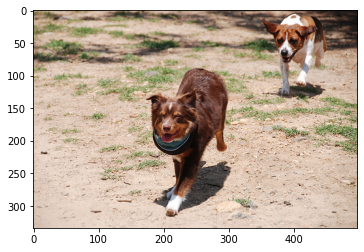

In [15]:
i=0
j=1
plt.imshow(X[i][j]),Y[i][j]

In [16]:
pickle.dump(X, open("X.p", "wb"))
pickle.dump(Y, open('Y.p', 'wb'))

## Load processed data

In [3]:
x_batch = []
for itr in tqdm(range(10,40)):
    x_hidden = pickle.load(open("../data/x_preprocessed_{}.p".format(itr), "rb"))
    x_batch.append(x_hidden)
x_batch = torch.cat(x_batch)


100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


In [4]:
x = x_batch.reshape(-1,1000)
diff = x - torch.mean(x,0)
c = torch.mm(diff.T,diff)/(x.shape[0])
weight = 1
torch.inverse(c*weight),c*weight

(tensor([[ 398.0907, -589.3714, -426.5718,  ..., -382.4142, -472.8737,
          -401.0356],
         [-582.8561,  325.2067, -375.0967,  ..., -323.5834, -478.0731,
          -448.1599],
         [-418.8118, -372.7848,  204.8530,  ..., -379.1984, -379.1223,
          -390.3397],
         ...,
         [-378.1104, -324.7184, -382.0811,  ...,  160.8044, -432.0879,
          -393.8497],
         [-463.9442, -475.2471, -378.6270,  ..., -428.2905,   84.5664,
          -441.3550],
         [-396.2326, -449.5488, -394.0135,  ..., -393.4274, -445.4061,
          -140.3520]]),
 tensor([[ 4.6795,  1.4572,  0.2809,  ...,  1.2413,  0.7137, -2.2133],
         [ 1.4572,  3.5546, -0.1295,  ...,  1.2056,  1.0536, -0.6783],
         [ 0.2809, -0.1295,  4.2578,  ..., -1.0180, -0.9556, -0.1864],
         ...,
         [ 1.2413,  1.2056, -1.0180,  ...,  5.3146,  2.6916, -0.0092],
         [ 0.7137,  1.0536, -0.9556,  ...,  2.6916,  4.0773,  0.0982],
         [-2.2133, -0.6783, -0.1864,  ..., -0.0092,  0.09

In [7]:
eigen_vals, eigen_vecs = np.linalg.eig(c)


In [8]:
eigen_vecs_sorted = np.array([x for _, x in sorted(zip(eigen_vals, eigen_vecs), key=lambda pair: pair[0], reverse=True)])
eigen_vals_sorted = sorted(eigen_vals, reverse=True)


In [27]:

W = eigen_vecs_sorted[:,:20]
X_train_pca = x_batch.reshape(-1,1000).numpy().dot(W)
x_eigenval = eigen_vals_sorted[:20]

In [28]:
x_rescale = X_train_pca/np.sqrt(x_eigenval)

In [35]:
np.var(X_train_pca,0),(eigen_vals[:20])
np.var(X_train_pca/(0.4*np.sqrt(eigen_vals[:20])))

3.1969967

In [25]:
np.sum(eigen_vals**2),np.sum(eigen_vals[:20]**2)

(1344533.0, 1321777.5)

In [16]:
np.sqrt(eigen_vals[:10]),np.mean(np.abs(X_train_pca),0)

(array([27.469261 , 23.905146 , 20.905186 , 16.984272 , 14.937915 ,
        12.212075 , 11.702934 , 11.094385 ,  9.584801 ,  8.7316475],
       dtype=float32),
 array([11.701926 , 16.194998 , 11.824864 ,  9.973701 ,  6.2472777,
         7.162909 ,  7.6954036,  6.642622 ,  6.3741536,  4.9811726],
       dtype=float32))

In [42]:
x = torch.Tensor(X_train_pca/(0.4*np.sqrt(x_eigenval))).reshape(-1,60)
diff = x - torch.mean(x,0)
c = torch.mm(diff.T,diff)/(x.shape[0])
weight = 1
torch.inverse(c*weight),c*weight

(tensor([[ 8.4495e+00, -3.3894e+00,  2.0879e+00,  ..., -6.1171e-03,
           8.8896e-02, -1.6018e-01],
         [-3.3894e+00,  9.4922e+00,  2.6888e+00,  ...,  2.7616e-02,
           1.6671e-02,  6.3390e-02],
         [ 2.0879e+00,  2.6888e+00,  7.5287e+00,  ...,  7.3087e-02,
          -2.3211e-02,  3.6382e-02],
         ...,
         [-6.1174e-03,  2.7616e-02,  7.3087e-02,  ...,  1.0472e+00,
           1.0682e-01, -1.0646e-01],
         [ 8.8896e-02,  1.6670e-02, -2.3211e-02,  ...,  1.0682e-01,
           7.9288e-01, -9.3020e-03],
         [-1.6017e-01,  6.3389e-02,  3.6382e-02,  ..., -1.0646e-01,
          -9.3020e-03,  1.0869e+00]]),
 tensor([[ 1.4859,  1.1786, -0.7461,  ..., -0.0162,  0.1091, -1.0447],
         [ 1.1786,  1.7177, -1.0356,  ..., -0.0736,  0.1259, -0.6985],
         [-0.7461, -1.0356,  1.0401,  ...,  0.0642, -0.0590,  0.5427],
         ...,
         [-0.0162, -0.0736,  0.0642,  ...,  2.0503, -0.0846,  0.0176],
         [ 0.1091,  0.1259, -0.0590,  ..., -0.0846,  2.3

In [43]:
torch.det(c)

tensor(1929.0614)

In [34]:
poolmax = torch.nn.MaxPool1d(10)
poolavg = torch.nn.AvgPool1d(10)
# x_pooled = torch.cat([poolmax(x_batch).reshape(-1,150), poolavg(x_batch).reshape(-1,150)],1)
# x_pooled = poolavg(poolmax(x_batch))
x_pooled = poolavg(torch.Tensor(x_normalized).reshape(-1,3,1000))
x_pooled.shape

torch.Size([536108, 3, 100])

In [4]:
x_normalized = normalize(x_batch.reshape(-1,1000),norm='l2')

In [61]:
(x_batch[0][0]/torch.sqrt(torch.sum(x_batch[0][0].pow(2))))*np.sqrt(1000)

tensor([-8.9327e-01, -1.2378e+00, -7.9297e-01, -1.1187e+00, -7.6943e-01,
        -1.1917e+00, -7.2888e-01,  3.6464e-01, -4.6883e-01, -7.1807e-01,
        -1.3333e+00, -6.8118e-01, -6.6675e-01, -9.2980e-01, -1.6044e+00,
        -8.4271e-01, -1.0376e+00, -7.5440e-01, -3.8001e-01, -9.8751e-01,
        -1.4768e+00, -6.7508e-01,  3.5780e-01, -1.0933e-01,  2.7557e-01,
        -1.1814e+00, -2.1774e+00, -1.6569e+00, -1.2473e+00, -2.0438e+00,
        -1.8213e+00, -1.6126e+00, -1.8267e+00,  5.6789e-02, -5.6281e-02,
        -1.4318e+00, -5.8311e-01, -6.8929e-01, -1.0791e+00,  2.0872e-01,
        -4.9944e-01, -6.7747e-01, -9.9961e-01, -1.0326e+00, -7.6003e-01,
        -5.0440e-01, -9.0475e-01, -1.8507e+00, -3.5492e-01, -1.1514e+00,
        -8.3909e-01,  9.6102e-01, -7.2379e-01, -5.9758e-01, -1.0773e+00,
        -2.6549e-01, -2.6350e-01, -1.1959e+00, -1.2148e+00, -2.5945e-01,
         5.4152e-01, -3.6524e-01, -4.0534e-01, -7.8376e-01, -6.0902e-01,
        -7.0729e-01, -1.1218e+00, -2.0478e-01, -1.0

In [233]:
poolavg = torch.nn.AvgPool1d(16)
x_pooled = poolavg(x_hidden)
x_pooled.shape

torch.Size([11148, 3, 128])

In [246]:
x = torch.Tensor(x_pooled[:500].reshape(-1,128*3))*13
diff = x - torch.mean(x,0)
c = torch.mm(diff.T,diff)/(x.shape[0])
weight = 1
torch.inverse(c*weight),c*weight

(tensor([[ 3.3308e+00, -8.0698e-01, -3.6087e-01,  ...,  6.3819e-02,
           2.0998e-02,  3.8903e-02],
         [-8.0698e-01,  3.0601e+00,  3.7466e-01,  ..., -1.3429e-01,
           1.1449e-01,  9.7519e-02],
         [-3.6088e-01,  3.7467e-01,  3.1072e+00,  ..., -2.6397e-03,
           2.8547e-02,  4.8996e-02],
         ...,
         [ 6.3819e-02, -1.3429e-01, -2.6392e-03,  ...,  1.6330e+00,
          -1.2923e-01, -4.4870e-02],
         [ 2.0997e-02,  1.1449e-01,  2.8547e-02,  ..., -1.2923e-01,
           1.9107e+00, -1.5095e-01],
         [ 3.8902e-02,  9.7519e-02,  4.8997e-02,  ..., -4.4869e-02,
          -1.5095e-01,  2.3244e+00]]),
 tensor([[ 3.3054,  0.8172,  0.2084,  ...,  0.4807,  0.4283,  0.5414],
         [ 0.8172,  1.7608,  0.6039,  ...,  0.1785,  0.4505,  0.3388],
         [ 0.2084,  0.6039,  3.1566,  ..., -0.1507,  0.1396,  0.0370],
         ...,
         [ 0.4807,  0.1785, -0.1507,  ...,  2.8674,  0.9206,  1.4439],
         [ 0.4283,  0.4505,  0.1396,  ...,  0.9206,  2.2

In [247]:
torch.det(c),torch.var(x)

(tensor(0.), tensor(3.3515))

In [5]:
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler,normalize
import sklearn

pca = PCA(n_components=110)


In [ ]:
scaler = StandardScaler()
x_ = scaler.fit_transform(x_batch.reshape(-1,1000))
x_

In [6]:
x_pca = pca.fit_transform(torch.Tensor(x_normalized*100))

In [8]:
x_pca.shape

(1608324, 110)

In [19]:
x = torch.Tensor(x_pca)[:,:100].reshape(-1,300)
diff = x - torch.mean(x,0)
c = torch.mm(diff.T,diff)/x.shape[0]
weight = 1
torch.inverse(c*weight),c*weight

(tensor([[ 9.0317e-03, -1.0727e-02,  1.0415e-02,  ..., -4.5695e-04,
          -1.2197e-03,  3.6787e-04],
         [-1.0727e-02,  2.8769e-02, -2.4064e-02,  ..., -3.3661e-04,
           7.6588e-04,  1.5318e-04],
         [ 1.0415e-02, -2.4064e-02,  2.9131e-02,  ...,  1.2058e-04,
          -1.4582e-04, -1.7305e-04],
         ...,
         [-4.5695e-04, -3.3661e-04,  1.2058e-04,  ...,  1.1960e-01,
           2.0947e-04, -3.3527e-03],
         [-1.2197e-03,  7.6588e-04, -1.4582e-04,  ...,  2.0947e-04,
           1.2405e-01, -4.0895e-03],
         [ 3.6787e-04,  1.5318e-04, -1.7305e-04,  ..., -3.3527e-03,
          -4.0895e-03,  1.2563e-01]]),
 tensor([[ 1.1186e+03,  2.1935e+02, -1.9824e+02,  ..., -1.7123e-01,
           6.0268e+00, -4.5819e-01],
         [ 2.1935e+02,  4.9016e+02,  2.4915e+02,  ...,  3.5331e-01,
          -1.1502e+00,  3.4988e-01],
         [-1.9824e+02,  2.4915e+02,  4.1907e+02,  ..., -7.1705e-01,
          -1.7880e+00,  1.2461e+00],
         ...,
         [-1.7123e-01,  3

In [45]:
torch.det(torch.inverse(c))

tensor(0.)

In [18]:
torch.det(c)

tensor(0.)